# Spaceship Titanic Preprocessing

**Description:**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!
___

# 1.Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='darkgrid', font_scale=2)
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

In [2]:
COMPARING_MODELS = True
DEBUG = True
VISUALIZING = False

# 2. Loading Data

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

df_train.head() if VISUALIZING else None

**Columns Description**
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# 3. Exploring/Viewing Data

In [4]:
if VISUALIZING:
    r1,c1 = df_train.shape
    print('The training data has {} rows and {} columns'.format(r1,c1))
    r2,c2 = df_test.shape
    print('The validation data has {} rows and {} columns'.format(r2,c2))

In [5]:
df_train.info() if VISUALIZING else None

In [6]:
df_train.describe() if VISUALIZING else None

In [7]:
df_test.describe() if VISUALIZING else None

## 3.B Fixing Missing Values 

In [8]:
if VISUALIZING:
    print('MISSING VALUES IN TRAINING DATASET:')
    print(df_train.isna().sum().nlargest(c1))
    print('')
    print('MISSING VALUES IN VALIDATION DATASET:')
    print(df_test.isna().sum().nlargest(c2))

In [9]:
df_train.set_index('PassengerId',inplace=True)
df_test.set_index('PassengerId',inplace=True)

## 3.C Null Replacement 

In [10]:
df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)
df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)

df_train['Age'] =df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] =df_test['Age'].fillna(df_test['Age'].median())

df_train['VIP'] =df_train['VIP'].fillna(False)
df_test['VIP'] =df_test['VIP'].fillna(False)

df_train['HomePlanet'] =df_train['HomePlanet'].fillna('Mars')
df_test['HomePlanet'] =df_test['HomePlanet'].fillna('Mars')

df_train['Destination']=df_train['Destination'].fillna("PSO J318.5-22")
df_test['Destination']=df_test['Destination'].fillna("PSO J318.5-22")

df_train['CryoSleep'] =df_train['CryoSleep'].fillna(False)
df_test['CryoSleep'] =df_test['CryoSleep'].fillna(False)

df_train['Cabin'] =df_train['Cabin'].fillna('T/0/P')
df_test['Cabin'] =df_test['Cabin'].fillna('T/0/P')

# 4. Exploration and Visualization 

In [11]:
plt.figure(figsize=(15,18)) if VISUALIZING else None
sns.heatmap(df_train.select_dtypes("number").corr(), annot=True) if VISUALIZING else None

In [12]:
plt.pie(df_train.Transported.value_counts(), shadow=True, explode=[.1,.1], autopct='%.1f%%') if VISUALIZING else None
plt.title('Transported ', size=18) if VISUALIZING else None
plt.legend(['False', 'True'], loc='best', fontsize=12) if VISUALIZING else None
plt.show() if VISUALIZING else None

In [13]:
sns.countplot(df_train, x="Transported") if VISUALIZING else None

In [14]:
sns.countplot(df_train, x="HomePlanet", hue="Transported") if VISUALIZING else None

In [15]:
sns.countplot(df_train, x="VIP", hue="Transported") if VISUALIZING else None

In [16]:
sns.countplot(df_train, x="CryoSleep", hue="Transported") if VISUALIZING else None

In [17]:
sns.countplot(df_train, x="Destination", hue="Transported") if VISUALIZING else None
plt.xticks(rotation=30) if VISUALIZING else None

In [18]:
sns.boxplot(df_train, y="Age", x="Transported") if VISUALIZING else None # Age will be divided into groups later

## 4.B Splitting Cabin Column

In [19]:
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
df_train[['Deck', 'Cabin_Num', 'Side']] = df_train.Cabin.str.split('/',expand=True)
df_test[['Deck', 'Cabin_Num', 'Side']] = df_test.Cabin.str.split('/',expand=True)

df_train['Cabin_Num'] = pd.to_numeric(df_train['Cabin_Num'], downcast='integer')
df_test['Cabin_Num'] = pd.to_numeric(df_test['Cabin_Num'], downcast='integer')

df_train['Side'] = df_train['Side'].map({'P':0,'S':1})
df_test['Side'] = df_test['Side'].map({'P':0,'S':1})

In [20]:
sns.countplot(df_train, y="Deck", hue="Transported", order=["A", "B", "C", "D", "E", "F", "T"]) if VISUALIZING else None

In [21]:
plt.figure(figsize=(10,5)) if VISUALIZING else None
sns.histplot(df_train, x='Cabin_Num', hue='Transported', bins=14, multiple="dodge", shrink=0.6) if VISUALIZING else None

In [22]:
sns.countplot(df_train, x="Side", hue="Transported") if VISUALIZING else None

In [23]:
sns.countplot(df_test, x="Side") if VISUALIZING else None

# 5. Feature Engineering

In [24]:
df_train['total_spent'] = df_train['RoomService'] + df_train['FoodCourt'] + df_train['ShoppingMall'] + df_train['Spa'] + df_train['VRDeck']
df_test['total_spent'] = df_test['RoomService'] + df_test['FoodCourt'] + df_test['ShoppingMall'] + df_test['Spa'] + df_test['VRDeck']

In [25]:
df_train['AgeGroup'] = 0
for i in range(6):
    df_train.loc[(df_train.Age >= 10*i) & (df_train.Age < 10*(i + 1)), 'AgeGroup'] = i
# Same for test data
df_test['AgeGroup'] = 0
for i in range(6):
    df_test.loc[(df_test.Age >= 10*i) & (df_test.Age < 10*(i + 1)), 'AgeGroup'] = i

In [26]:
sns.countplot(y=df_train['AgeGroup'], hue=df_train['Transported']) if VISUALIZING else None

## 6.B drop target

In [27]:
df_train['Transported'] = df_train['Transported'].replace({True:1,False:0})

# 6. Pre processing

In [28]:
if DEBUG:
    df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=42)
    y_test = df_test["Transported"]

X_test = df_test.drop(columns=["Transported"]) if DEBUG else df_test

X_train, y_train = (
    df_train.drop(columns=["Transported"]),
    df_train["Transported"],
)

## 6.A Encoding

In [29]:
numeric_feats = [
    "total_spent",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]
log_numeric_feats = [
    "Cabin_Num",
]
ordinal_feats = [
    "AgeGroup",
]
categorical_feats = [
    "HomePlanet",
    "Destination",
    "Deck",
]
binary_feats = [
    "VIP",
    "CryoSleep",
    "Side",    
]
drop_feats = [
    "Cabin",
    "Name",
    "Age",
]

In [30]:
ct = make_column_transformer(
    (RobustScaler(), numeric_feats),
    (
        make_pipeline(
            PowerTransformer(),
            RobustScaler()
        ),
        log_numeric_feats
    ),
    (OneHotEncoder(), categorical_feats),
    (OrdinalEncoder(), binary_feats),
    (OrdinalEncoder(), ordinal_feats),
    ("drop", drop_feats),
)

In [31]:
ct if VISUALIZING else None

In [32]:
transformed = ct.fit_transform(X_train)

In [33]:
column_names = ct.get_feature_names_out()
clean_names = [name.split("__", 1)[-1] for name in column_names]

transformed = pd.DataFrame(transformed, columns=clean_names)

In [34]:
pd.DataFrame(transformed).head() if VISUALIZING else None

## 6.B Heatmap

In [35]:
plt.figure(figsize=(55,30)) if VISUALIZING else None
sns.heatmap(transformed.corr(), annot=True) if VISUALIZING else None

# 7. Models

In [36]:
results = {}
best_models = {}

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## 7.A SVM

### Linear Kernel

In [37]:
grid_search = GridSearchCV(
    estimator=make_pipeline(ct, SVC(kernel='linear')),
    param_grid={
        'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'svc__max_iter': [500, 1000],
    },
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

,Hyperparameter,Best Value
0,svc__C,1
1,svc__max_iter,1000


In [38]:
svm_linear_model = make_pipeline(ct, SVC(C=1, max_iter=1000)).fit(X_train, y_train)
svm_linear_model if VISUALIZING else None

In [39]:
y_pred = svm_linear_model.predict(X_test)

In [40]:
accuracy_score(y_test, y_pred) if DEBUG else None

0.6149954001839927

In [41]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

In [42]:
sub.to_csv("../predictions/svm_linear_optimized.csv")

### RBF Kernel

In [43]:
grid_search = GridSearchCV(
    estimator=make_pipeline(ct, SVC(kernel='rbf')),
    param_grid={
        'svc__C': [0.01, 0.1, 1, 10, 100, 1000],
        'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]
    },
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

,Hyperparameter,Best Value
0,svc__C,100.0000
1,svc__gamma,0.0001


In [44]:
svm_rbf_model = make_pipeline(ct, SVC(C=100, gamma=0.0001)).fit(X_train, y_train)
svm_rbf_model if VISUALIZING else None

In [45]:
y_pred = svm_rbf_model.predict(X_test)

In [46]:
accuracy_score(y_test, y_pred) if DEBUG else None

0.7861085556577737

In [47]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

In [48]:
sub.to_csv("../predictions/svm_rbf_optimized.csv")

## 7.B KNN Classifier

In [49]:
grid_search = GridSearchCV(
    estimator=make_pipeline(ct, KNeighborsClassifier()),
    param_grid={
        "kneighborsclassifier__n_neighbors": [1, 3, 5, 7, 9, 11, 15, 21, 25],
        "kneighborsclassifier__weights": ["uniform", "distance"],
        "kneighborsclassifier__metric": ["euclidean", "manhattan"]
    },
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

,Hyperparameter,Best Value
0,kneighborsclassifier__metric,euclidean
1,kneighborsclassifier__n_neighbors,25
2,kneighborsclassifier__weights,uniform


In [50]:
knn_model = make_pipeline(ct, KNeighborsClassifier(metric='euclidean', n_neighbors=25, weights='uniform')).fit(X_train, y_train)
knn_model if VISUALIZING else None

In [51]:
y_pred = knn_model.predict(X_test)

In [52]:
accuracy_score(y_test, y_pred) if DEBUG else None

0.7907083716651334

In [53]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

In [54]:
sub.to_csv("../predictions/knn.csv")

## 7.C Logistic Regression 

In [55]:
grid_search = GridSearchCV(
    estimator=make_pipeline(ct, LogisticRegression()),
    param_grid={
        "logisticregression__penalty": ["l1", "l2"],
        "logisticregression__solver": ["liblinear", "lbfgs"],
        "logisticregression__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        "logisticregression__max_iter": [1000],
    },
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

,Hyperparameter,Best Value
0,logisticregression__C,0.1
1,logisticregression__max_iter,1000
2,logisticregression__penalty,l2
3,logisticregression__solver,lbfgs


In [56]:
logreg_model = make_pipeline(ct, LogisticRegression(C=0.1, max_iter=1000, penalty='l2', solver='lbfgs')).fit(X_train, y_train)
logreg_model if VISUALIZING else None

In [57]:
y_pred = logreg_model.predict(X_test)

In [58]:
accuracy_score(y_test, y_pred) if DEBUG else None

0.7847286108555658

In [59]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

In [60]:
sub.to_csv("../predictions/logistic_reg.csv")

## 7.D kMeans

In [61]:
def evaluate_kmeans(X, ks=range(2, 11)):
    silhouettes = []
    inertias = []

    for k in ks:
        km = KMeans(n_clusters=k, init="k-means++", n_init=20)
        labels = km.fit_predict(X)
        silhouettes.append(silhouette_score(X, labels))
        inertias.append(km.inertia_)
    
    return np.array(silhouettes), np.array(inertias)

In [62]:
X_train_kmeans = pd.DataFrame(ct.transform(X_train), columns=clean_names)
X_test_kmeans = pd.DataFrame(ct.transform(X_test), columns=clean_names)

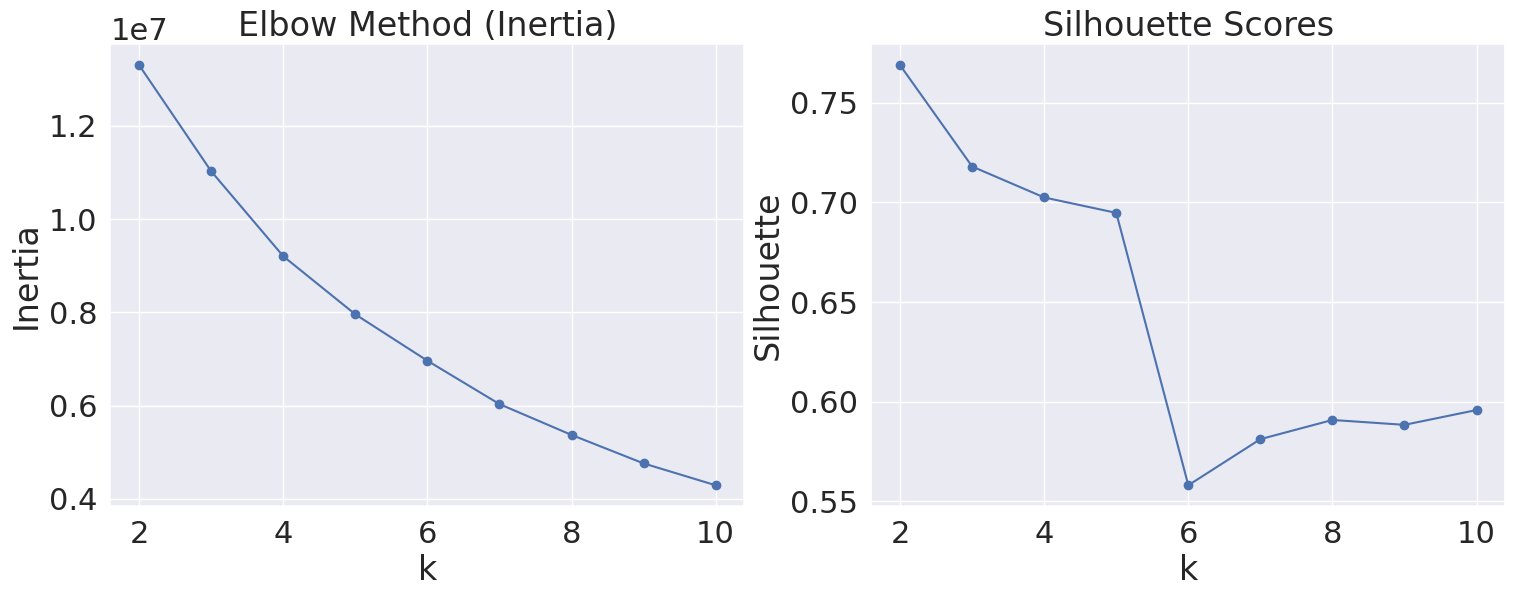

In [63]:
if COMPARING_MODELS: 
    sil, ine = evaluate_kmeans(X_train_kmeans)
    
    ks = range(2, 11)
    
    plt.figure(figsize=(18,6))
    
    plt.subplot(1,2,1)
    plt.plot(ks, ine, marker="o")
    plt.title("Elbow Method (Inertia)")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    
    plt.subplot(1,2,2)
    plt.plot(ks, sil, marker="o")
    plt.title("Silhouette Scores")
    plt.xlabel("k")
    plt.ylabel("Silhouette")

plt.show() if COMPARING_MODELS else None

In [64]:
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=20)
kmeans.fit(transformed)

X_train_kmeans['Cluster'] = kmeans.predict(X_train_kmeans)
X_test_kmeans['Cluster'] = kmeans.predict(X_test_kmeans)

In [65]:
grid_search = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid={
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_kmeans, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

,Hyperparameter,Best Value
0,C,100.0000
1,gamma,0.0001


In [66]:
svc_model = SVC(C=100, gamma=0.0001)
svc_model if VISUALIZING else None

In [67]:
svc_model.fit(X_train_kmeans, y_train)
y_pred = svc_model.predict(X_test_kmeans)

In [68]:
accuracy_score(y_test, y_pred) if DEBUG else None

0.7861085556577737

In [69]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

In [70]:
sub.to_csv("../predictions/kmeans.csv")

## 7.E DBSCAN

In [71]:
def optimize_dbscan_to_df(
    X,
    min_samples_candidates=None,
    eps_percentiles=[50, 75, 90],
    n_eps=20,
    top_n=5,
):
    X = StandardScaler().fit_transform(X)
    dim = X.shape[1]

    if min_samples_candidates is None:
        min_samples_candidates = sorted(list(set([3, 5, 10, dim + 1])))

    results = []
    detailed = []  # includes labels

    for min_s in min_samples_candidates:
        nbrs = NearestNeighbors(n_neighbors=min_s).fit(X)
        distances, _ = nbrs.kneighbors(X)
        k_dist = np.sort(distances[:, -1])

        eps_vals = np.percentile(k_dist, eps_percentiles)
        low, high = eps_vals[0], eps_vals[-1]
        eps_grid = np.linspace(max(1e-6, low * 0.5), high * 1.5, n_eps)

        for eps in eps_grid:
            model = DBSCAN(eps=eps, min_samples=min_s)
            labels = model.fit_predict(X)

            mask = labels != -1
            unique_clusters = np.unique(labels[mask])

            if len(unique_clusters) < 2:
                score = -np.inf
            else:
                try:
                    score = silhouette_score(X[mask], labels[mask])
                except:
                    score = -np.inf

            meta = {
                "eps": eps,
                "min_samples": min_s,
                "score": score,
                "n_clusters": len(unique_clusters),
                "noise_frac": 1 - np.mean(mask),
            }

            results.append(meta)
            detailed.append({**meta, "labels": labels})

    # Sort by score
    results_sorted = sorted(detailed, key=lambda x: x["score"], reverse=True)

    # Build DataFrame of top-N
    df = pd.DataFrame([{k: v for k, v in r.items() if k != "labels"}
                       for r in results_sorted[:top_n]])

    return df, results_sorted[:top_n]

In [72]:
X_train_DBS = pd.DataFrame(ct.transform(X_train), columns=clean_names)
X_test_DBS = pd.DataFrame(ct.transform(X_test), columns=clean_names)

In [73]:
df, full_results = optimize_dbscan_to_df(X_train_DBS) if COMPARING_MODELS else None
df if COMPARING_MODELS else None

,eps,min_samples,score,n_clusters,noise_frac
0,0.268023,3,0.497309,256,0.635987
1,0.689217,26,0.474831,21,0.847216
2,0.468423,10,0.449682,62,0.748274
3,0.375039,5,0.447793,142,0.661298
4,0.951813,26,0.437265,24,0.547323


In [74]:
dbscan = DBSCAN(eps=0.268023, min_samples=3)
dbscan if VISUALIZING else None

In [75]:
dbscan.fit(X_train_DBS)
dbscan_train_labels = dbscan.labels_

In [76]:
# use knn to predict which cluster to be in
cluster_predictor = KNeighborsClassifier(n_neighbors=10)
cluster_predictor.fit(X_train_DBS, dbscan_train_labels)
dbscan_test_labels = cluster_predictor.predict(X_test_DBS)

In [77]:
# make augmented dataframe - original data + cluster predicted
X_train_augmented = X_train_DBS.copy()
X_train_augmented['DBSCAN_Cluster'] = dbscan_train_labels

X_test_augmented = X_test_DBS.copy()
X_test_augmented['DBSCAN_Cluster'] = dbscan_test_labels

In [78]:
grid_search = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid={
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_augmented, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(grid_search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

,Hyperparameter,Best Value
0,C,100.0000
1,gamma,0.0001


In [79]:
svc_DBS = SVC(C=100, gamma=0.0001)
svc_DBS if VISUALIZING else None

In [80]:
svc_DBS.fit(X_train_augmented, y_train)
y_pred = svc_DBS.predict(X_test_augmented)

In [81]:
accuracy_score(y_test, y_pred) if DEBUG else None

0.7870285188592456

In [82]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

In [83]:
sub.to_csv("../predictions/dbscan.csv")

## 7.E RandomForestClassifier

In [84]:
search = RandomizedSearchCV(
    estimator=make_pipeline(ct, RandomForestClassifier()),
    param_distributions ={
        "randomforestclassifier__n_estimators": [200, 400, 800],
        "randomforestclassifier__max_depth": [None, 10, 30],
        "randomforestclassifier__min_samples_split": [2, 10],
        "randomforestclassifier__min_samples_leaf": [1, 4],
        "randomforestclassifier__max_features": ["sqrt", "log2"],
    },
    cv=3,
    scoring='roc_auc',
    n_iter=50,
    n_jobs=-1
)

search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

,Hyperparameter,Best Value
0,randomforestclassifier__n_estimators,800
1,randomforestclassifier__min_samples_split,10
2,randomforestclassifier__min_samples_leaf,4
3,randomforestclassifier__max_features,sqrt
4,randomforestclassifier__max_depth,None


In [85]:
random_forest_model = make_pipeline(ct, RandomForestClassifier(n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=30)).fit(X_train, y_train)
random_forest_model if VISUALIZING else None

In [86]:
y_pred = random_forest_model.predict(X_test)

In [87]:
accuracy_score(y_test, y_pred) if DEBUG else None

0.7911683532658693

In [88]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

In [89]:
sub.to_csv("../predictions/random_forest.csv")

## 7.F GradientBoostingClassifier

In [90]:
search = RandomizedSearchCV(
    estimator=make_pipeline(ct, GradientBoostingClassifier()),
    param_distributions ={
        "gradientboostingclassifier__n_estimators": [100, 200, 300],
        "gradientboostingclassifier__learning_rate": [0.01, 0.05, 0.1],
        "gradientboostingclassifier__max_depth": [2, 3, 4],
        "gradientboostingclassifier__subsample": [0.7, 1.0],
        "gradientboostingclassifier__max_features": ["sqrt", "log2"],
    },
    cv=5,
    scoring='roc_auc',
    n_iter=50,
    n_jobs=-1
)

search.fit(X_train, y_train) if COMPARING_MODELS else None
pd.DataFrame(list(search.best_params_.items()), columns=['Hyperparameter', 'Best Value']) if COMPARING_MODELS else None

,Hyperparameter,Best Value
0,gradientboostingclassifier__subsample,1.0
1,gradientboostingclassifier__n_estimators,300
2,gradientboostingclassifier__max_features,log2
3,gradientboostingclassifier__max_depth,4
4,gradientboostingclassifier__learning_rate,0.1


In [91]:
gradient_boost_model = make_pipeline(ct, GradientBoostingClassifier(subsample=0.7, n_estimators=300, max_features='sqrt', max_depth=4, learning_rate=0.05)).fit(X_train, y_train)
gradient_boost_model if VISUALIZING else None

In [92]:
y_pred = gradient_boost_model.predict(X_test)

In [93]:
accuracy_score(y_test, y_pred) if DEBUG else None

0.8003679852805887

In [94]:
sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index=df_test.index)
sub.head() if VISUALIZING else None

In [95]:
sub.to_csv("../predictions/gradient_boost.csv")

## 7.G Voting Classifier

### 7.G.1 Setup

In [96]:
best_models = {"LR": LogisticRegression()} if len(best_models) == 0 else best_models # TODO: add best models to best_models dict

estimators = []
for name, model in best_models.items():
    pipe = make_pipeline(ct, model)
    estimators.append((name, pipe))

print(best_models)

{'LR': LogisticRegression()}


### 7.G.2 Soft Voting

In [97]:
soft_voting_model = VotingClassifier(estimators, voting='soft')
soft_voting_model.fit(X_train, y_train)
y_pred = soft_voting_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7861085556577737

In [98]:
sub = pd.DataFrame({'Transported': y_pred.astype(bool)}, index=df_test.index)
sub.to_csv("../predictions/voting_classifier.csv")


### 7.G.3 Hard Voting

In [99]:

soft_voting_model = VotingClassifier(estimators, voting='soft')
soft_voting_model.fit(X_train, y_train)
y_pred = soft_voting_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7861085556577737

In [100]:
sub = pd.DataFrame({'Transported': y_pred.astype(bool)}, index=df_test.index)
sub.to_csv("../predictions/voting_classifier.csv")